**1. IMPORTING THE DATASET**

In [59]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
oil_df = pd.read_csv('/content/oil.csv')

In [3]:
oil_df.shape

(1218, 2)

In [4]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


**2. PRE-PROCESSING THE DATA**

In [6]:
#change the datatype of 'date' col from object to datetime
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [8]:
#resetting the 'date' col as index
oil_df.set_index('date', inplace = True)

In [9]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


In [10]:
oil_df.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [11]:
oil_df.isna().sum()

,0
dcoilwtico,43


In [12]:
#handling the missing values
oil_df.dropna(inplace = True)

In [13]:
oil_df.isna().sum()

,0
dcoilwtico,0


In [14]:
oil_df.head()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21


In [15]:
#sorting the index
oil_df.sort_index(inplace = True)

**3. Normalizing the Data**

In [19]:
scaler = MinMaxScaler()
oil_df_scaled = scaler.fit_transform(oil_df.values)

In [20]:
oil_df_scaled

array([[0.79296459],
       [0.79095108],
       [0.7927277 ],
       ...,
       [0.24008054],
       [0.23415847],
       [0.24955585]])

In [21]:
oil_df_scaled = pd.DataFrame(oil_df_scaled, columns = ['dcoilwtico'], index = oil_df.index)

In [22]:
oil_df_scaled.head()

,dcoilwtico
date,
2013-01-02,0.792965
2013-01-03,0.790951
2013-01-04,0.792728
2013-01-07,0.793675
2013-01-08,0.793794


**4. Create the Sliding Window Sequences**

In [ ]:
# SLIDING WINDOW APPROACH
# window_size(look-back-period) = 3
# input         output
# [1, 2, 3]      [4]
# [2, 3, 4]      [5]
# [3, 4, 5]      [6]

In [27]:
window_size = 3

def create_sequence(data, window_size):
  X = []  #sequences
  y = []  #target
  for i in range(len(data) - window_size):
    X.append(data[i : i+window_size])
    y.append(data[i + window_size])
  return np.array(X), np.array(y)

X, y = create_sequence(oil_df_scaled['dcoilwtico'], window_size)

<ipython-input-27-9980effe8b5c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + window_size])


In [28]:
X.shape, y.shape

((1172, 3), (1172,))

In [29]:
X

array([[0.79296459, 0.79095108, 0.7927277 ],
       [0.79095108, 0.7927277 , 0.79367523],
       [0.7927277 , 0.79367523, 0.79379368],
       ...,
       [0.24931896, 0.25417506, 0.23936989],
       [0.25417506, 0.23936989, 0.24008054],
       [0.23936989, 0.24008054, 0.23415847]])

In [31]:
# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [33]:
X.shape, y.shape

(1172, 3, 1)

In [34]:
X_train, y_train = X[:937], y[:937]
X_test, y_test = X[937:], y[937:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((937, 3, 1), (937,), (235, 3, 1), (235,))

In [38]:
(X.shape[1], 1)

(3, 1)

**5. Building the LSTM model**

In [61]:
model = keras.Sequential([
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)),
    keras.layers.LSTM(units = 50, return_sequences = False),
    keras.layers.Dense(units = 25),
    keras.layers.Dense(units = 1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [64]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

In [72]:
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=1,
                    callbacks=[early_stopping])

Epoch 1/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - RootMeanSquaredError: 0.0361 - loss: 0.0013 - val_RootMeanSquaredError: 0.0231 - val_loss: 5.3218e-04
Epoch 2/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - RootMeanSquaredError: 0.0314 - loss: 0.0010 - val_RootMeanSquaredError: 0.0211 - val_loss: 4.4329e-04
Epoch 3/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - RootMeanSquaredError: 0.0265 - loss: 7.0546e-04 - val_RootMeanSquaredError: 0.0383 - val_loss: 0.0015
Epoch 4/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - RootMeanSquaredError: 0.0288 - loss: 8.3270e-04 - val_RootMeanSquaredError: 0.0213 - val_loss: 4.5207e-04
Epoch 5/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - RootMeanSquaredError: 0.0258 - loss: 6.7072e-04 - val_RootMeanSquaredError: 0.0430 - val_loss: 0.0018
Epoch 6/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - RootMeanSquaredError: 0.0318 - loss: 0.0010 - val_RootMeanSquaredError: 0.0211 - val_loss: 4.4395e-04
Epoch 7/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step 

In [73]:
prediction = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [74]:
prediction = scaler.inverse_transform(prediction)

In [75]:
actual_prediction = scaler.inverse_transform(y_test.reshape(-1, 1))

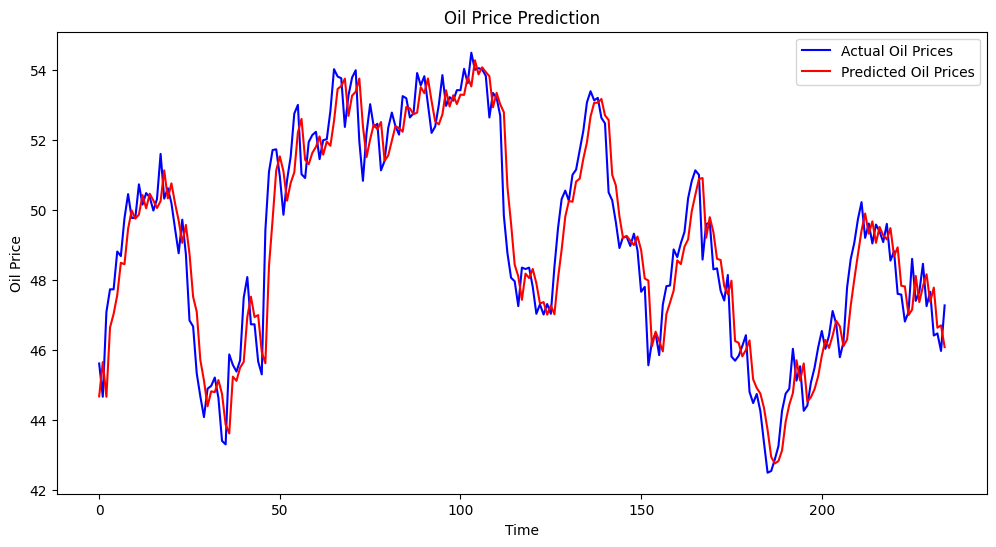

In [76]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prediction, color='blue', label='Actual Oil Prices')
plt.plot(prediction, color='red', label='Predicted Oil Prices')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()